# Part 5_b : Plot the training and validation error with respect to number of nodes in the decision tree.
<font color = blue>The idea is to store count of 0's and 1's at every node in the tree. <br>While predicting test data, whenever we reach a node whose total count (count of 0 + count of 1) is less than or equal to number of nodes in the tree, we can safely return the most probable answer at that node.<br> By doing this, we ensure that we are not going further down into the tree and.</blue>

In [77]:
# Import packages
import numpy as np
import pprint
import ipdb
import pandas as pd
import matplotlib.pyplot as plt
eps = np.finfo(float).eps
from numpy import log2 as log

In [78]:
# Load training data, split into train and validation sets
data = pd.read_csv("train.csv")
train_data = data.sample(frac=0.8)
val_data = data.drop(train_data.index)
discrete_attributes = ["Work_accident", "promotion_last_5years", "sales", "salary"]    
real_attributes = ["satisfaction_level", "last_evaluation", "number_project", "average_montly_hours", "time_spend_company"]

In [79]:
def entropy_before_split(train_data):
    """ Finds Entropy of dataset before any split """
    
    dependent_variable = "left"
    entropy = 0
    labels = train_data[dependent_variable].unique()
    for label in labels:
        temp = train_data[dependent_variable].value_counts()[label] / len(train_data[dependent_variable])
        entropy += -temp * log(temp + eps)
    return entropy

In [80]:
def entropy_on_real_attribute_split(train_data, attribute):
    """ Finds resulting entropy of dataset if it is split using attribute """
    
    dependent_variable = "left"
    class_labels = train_data[dependent_variable].unique()
    attribute_labels = train_data[attribute].unique()
    max_entropy = None
    split_point = None
    
    for attribute_label in attribute_labels:
        entropy = 0
        entropy_after_split = 0
        
        for class_label in class_labels:
            numer = len(train_data[attribute][train_data[attribute] <= attribute_label][train_data[dependent_variable] == class_label])
            denom = len(train_data[attribute][train_data[attribute] <= attribute_label])
            temp = numer / (denom + eps)
            entropy += -temp * log(temp + eps)
        temp2 = denom / len(train_data)
        entropy_after_split += -temp2 * entropy
        
        entropy = 0    
        for class_label in class_labels:
            numer = len(train_data[attribute][train_data[attribute] > attribute_label][train_data[dependent_variable] == class_label])
            denom = len(train_data[attribute][train_data[attribute] > attribute_label])
            temp = numer / (denom + eps)
            entropy += -temp * log(temp + eps)
        temp2 = denom / len(train_data)
        entropy_after_split += -temp2 * entropy
            
        if (max_entropy == None or (max_entropy > abs(entropy_after_split))):
            max_entropy = abs(entropy_after_split)
            split_point = attribute_label
        
    return max_entropy, split_point

In [81]:
def entropy_on_discrete_attribute_split(train_data, attribute):
    """ Finds resulting entropy of dataset if it is split using attribute """
    entropy_after_split = 0
    dependent_variable = "left"
    class_labels = train_data[dependent_variable].unique()
    attribute_labels = train_data[attribute].unique()

    for attribute_label in attribute_labels:
        entropy = 0
        for class_label in class_labels:
            numer = len(train_data[attribute][train_data[attribute] == attribute_label][train_data[dependent_variable] == class_label])
            denom = len(train_data[attribute][train_data[attribute] == attribute_label])
            temp = numer / (denom + eps)
            entropy += -temp * log(temp + eps)
        temp2 = denom / len(train_data)
        entropy_after_split += -temp2 * entropy
    return abs(entropy_after_split)

In [82]:
def split_criteria(train_data):
    """ Finds the best attribute to split on """
    
    Info_gain_discrete = {}
    initialEntropy = entropy_before_split(train_data)
    Info_gain = None
    split_point = None
    max_gain_attribute = None
    
    for key in discrete_attributes:
        Info_gain_discrete[key] = initialEntropy - entropy_on_discrete_attribute_split(train_data, key)
        
    for key in real_attributes:
        max_entropy, max_entropy_val = entropy_on_real_attribute_split(train_data, key)
        if (Info_gain == None or initialEntropy - max_entropy > Info_gain):
            Info_gain = initialEntropy - max_entropy
            split_point = max_entropy_val
            max_gain_attribute = key
             
    first = max(Info_gain_discrete, key=lambda k: Info_gain_discrete[k])
    if Info_gain_discrete[first] > Info_gain:
        Info_gain = Info_gain_discrete[first]
        max_gain_attribute = first
    return Info_gain, max_gain_attribute, split_point

In [83]:
def split_dataset_smaller(train_data, feature, split_point):
    return train_data[train_data[feature] <= split_point].reset_index(drop = True)

In [84]:
def split_dataset_greater(train_data, feature, split_point):
      return train_data[train_data[feature] > split_point].reset_index(drop = True)

In [85]:
def split_dataset(train_data, feature, label):
    """ This splits the dataset on given feature and all of its values """
    return train_data[train_data[feature] == label].reset_index(drop = True)

In [86]:
def most_probable(t_data):
    dependent_variable = "left"
    count_left = len(t_data[t_data[dependent_variable] == 0])
    count_right = len(t_data[t_data[dependent_variable] == 1])
    if count_left > count_right:
        return 0, count_left, count_right
    else:
        return 1, count_left, count_right

#### At each node we store total count of 0's and 1's

In [87]:
def Decision_tree(t_data):
    """ Builds tree recursively """
    
    D_tree = {}
    dependent_variable = "left"
    Info_gain, root, split_point = split_criteria(t_data)
    
    ans, zero_count, one_count = most_probable(t_data)
    
    if Info_gain == 0.0:
        return ans
    
    D_tree[root] = {}
    D_tree["zero_count"] = zero_count
    D_tree["one_count"] = one_count 
    
    if root in (discrete_attributes):
        labels = t_data[root].unique()
        for label in labels:
            split_data = split_dataset(t_data, root, label)
            unique_labels = split_data[dependent_variable].unique()
            if len(unique_labels) == 1:
                D_tree[root][label] = unique_labels[0]
            else:
                D_tree[root][label] = Decision_tree(split_data)
        return D_tree

    else:
        split_data = split_dataset_smaller(t_data, root, split_point)
        unique_labels = split_data[dependent_variable].unique()
        if len(unique_labels) == 1:
            D_tree[root][split_point] = unique_labels[0]
        else:
            D_tree[root][split_point] = Decision_tree(split_data)
            
        split_data = split_dataset_greater(t_data, root, split_point)
        unique_labels = split_data[dependent_variable].unique()
        if len(unique_labels) == 1:
            D_tree[root][split_point + 0.000000001] = unique_labels[0]
        else:
            D_tree[root][split_point + 0.000000001] = Decision_tree(split_data)
    
        return D_tree
    

#### While predicting, whenever total count is within the total number of nodes, we return the most probable answer from that node. This stops the algorithm from going further down into the tree.

In [88]:
def predict(inst, tree, node_count):
    
    zero_count = tree["zero_count"]
    one_count = tree["one_count"]
    
    if zero_count + one_count <= node_count :
        if zero_count >= one_count:
            return 0
        else:
            return 1

    tree_keys = list(tree.keys())

    index = 0
    if (tree_keys[0] == "one_count") or (tree_keys[0]=="zero_count"):
        if (tree_keys[1]=="one_count") or (tree_keys[1]=="zero_count"):
            nodes = tree_keys[2]
        else:
            nodes = tree_keys[1]
    else:
        nodes = tree_keys[0]
        
        
    value = inst[nodes]
    if nodes in discrete_attributes:
        if value in list((tree[nodes]).keys()):
            tree = tree[nodes][value]
        else:
            zeros = 0
            ones = 0
            for i in tree[nodes].keys():
                if tree[nodes][i] == 0:
                    zeros += 1
                elif tree[nodes][i] == 1:
                    ones += 1
            if zeros > ones:
                return 0
            else:
                return 1

    elif nodes in real_attributes:
        first_key = list(tree[nodes].keys())[0]
        if value <= first_key :
            tree = tree[nodes][first_key]
        else:
            second_key = list(tree[nodes].keys())[1]
            tree = tree[nodes][second_key]
    prediction = 0

    if type(tree) is dict:
        prediction = predict(inst, tree, node_count)
    else:
        prediction = tree
    
        
    return prediction

In [89]:
def validate_tree(val_data, tree, count):
    predicted = []
    for index, row in val_data.iterrows():
        predicted.append(predict(row, tree, count))
    actual = val_data["left"].tolist()
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    
    for i in range(0, len(predicted)):
        if (predicted[i] == 0 and actual[i] == 0):
            true_neg += 1
        elif (predicted[i] == 0 and actual[i] == 1):
            false_neg += 1
        elif (predicted[i] == 1 and actual[i] == 0):
            false_pos += 1
        else:
            true_pos += 1
    return true_pos, true_neg, false_pos, false_neg 
    
        

In [90]:
def accuracy(val_data, tree, count):
    true_pos, true_neg, false_pos, false_neg = validate_tree(val_data, tree, count)
    total_instances = true_neg + true_pos + false_neg + false_pos
    accuracy_estimate = (true_neg + true_pos) / (total_instances + eps)
    precision_estimate = true_pos / (true_pos + false_pos + eps)
    recall_estimate = (true_pos) / (true_pos + false_neg + eps)
    f1_score = (1 / recall_estimate) + (1 / precision_estimate + eps)
    f1_score = 2 / (f1_score + eps)
    return accuracy_estimate, precision_estimate, recall_estimate

In [91]:
def plot(tree):
#     tree = Decision_tree(train_data)
    validation_error = []
    node_count = range(10000, 200, -200)
    for count in node_count:
        accuracy_estimate, precision_estimate, recall_estimate = accuracy(val_data, tree, count)
        validation_error.append(1 - accuracy_estimate)
    
    fig, axes = plt.subplots(figsize=(12,6))
    axes.plot(node_count, validation_error, color="black", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="green", markeredgewidth=1, markeredgecolor="black");

    plt.title("Validation Error vs Tree Size")
    plt.ylabel("Validation Error")
    plt.xlabel("Tree Size")
    name="compare_validation_vs_size.png"
    plt.savefig(name,bbox_inches='tight')
    plt.show()

/home/kaushik/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


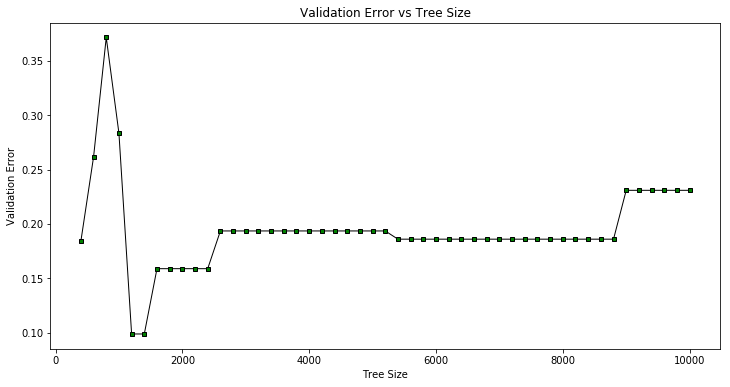

In [92]:
tree = Decision_tree(train_data)
plot(tree)